<a href="https://colab.research.google.com/github/oceam/agri-image/blob/main/codes/areacal_robo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# step1 download image

In [1]:
!gdown --id 1ZTKUhvqAIFh1HlJtSoMC800J5hvi_NUA

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZTKUhvqAIFh1HlJtSoMC800J5hvi_NUA
To: /content/rice stem prediction.v6i.yolov8.zip
100% 60.4M/60.4M [00:01<00:00, 33.8MB/s]


#step2 unzip image, prepare result folder

In [16]:
!mkdir /content/rawdata
!mkdir -p /content/results/{test,train,valid}

mkdir: cannot create directory ‘/content/rawdata’: File exists


In [6]:
!unzip '/content/rice stem prediction.v6i.yolov8.zip' -d '/content/rawdata/'

Archive:  /content/rice stem prediction.v6i.yolov8.zip
 extracting: /content/rawdata/README.roboflow.txt  
 extracting: /content/rawdata/data.yaml  
   creating: /content/rawdata/test/
   creating: /content/rawdata/test/images/
 extracting: /content/rawdata/test/images/101_0905G2_jpeg.rf.a4ab761e2c0d917b125cda295a9437b9.jpg  
 extracting: /content/rawdata/test/images/12_0901G1_JPG.rf.e629b77680547bcf3f4a8a2b3cd80fe1.jpg  
 extracting: /content/rawdata/test/images/143_0901G1_JPG.rf.4c3281418f2200d51abe0fe6e504dd46.jpg  
 extracting: /content/rawdata/test/images/153_0905G2_jpeg.rf.6e11b869bf65877d05bb90b2ba032197.jpg  
 extracting: /content/rawdata/test/images/157_0905G2_jpeg.rf.d629fb3a1527781aa2d4ebb17a59d2c2.jpg  
 extracting: /content/rawdata/test/images/26_0901G1_JPG.rf.c51e8a4d6c989757e0f23e0303e9ea96.jpg  
 extracting: /content/rawdata/test/images/34_0905G2_jpeg.rf.a3f989950cdb302cfb0264de6906fae9.jpg  
 extracting: /content/rawdata/test/images/36_0905G2_jpeg.rf.e345352cd6b78a9a62

#step3 check the annotation

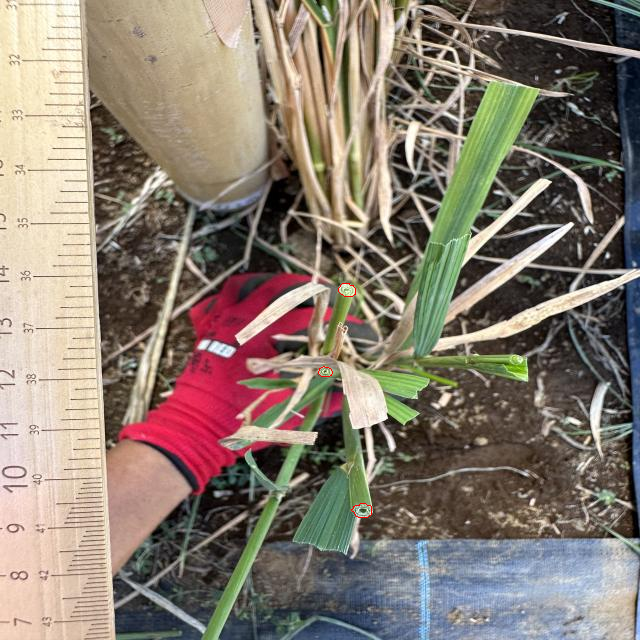

In [12]:
from PIL import Image, ImageDraw
from IPython.display import display

def draw_yolo_segmentation(image_path, annotation_content):
    # Load the image
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        width, height = img.size

        # Iterate through each annotation line
        for line in annotation_content:
            # Parse the line to get class_id and polygon points
            parts = line.strip().split()
            points = list(map(float, parts[1:]))  # Skip the class_id
            polygon = [(points[i] * width, points[i + 1] * height) for i in range(0, len(points), 2)]

            # Draw polygon
            draw.polygon(polygon, outline="red")

        # Return the image object
        return img

# Read the annotation file
with open('/content/rawdata/test/labels/101_0905G2_jpeg.rf.a4ab761e2c0d917b125cda295a9437b9.txt', 'r') as file:
    annotation_content = file.readlines()

# Call the function and display the image
example_image_path = '/content/rawdata/test/images/101_0905G2_jpeg.rf.a4ab761e2c0d917b125cda295a9437b9.jpg'
annotated_img = draw_yolo_segmentation(example_image_path, annotation_content)
display(annotated_img)


#step4 read all image and annotation file, calculate area, save to csv
This script will process each image in the "images" folder, find the corresponding label file in the "labels" folder, annotate the image, calculate the areas, and then save both the annotated image and the CSV file to the "results" folder.

In [17]:
from PIL import Image, ImageDraw
import csv
import numpy as np
import os

def calculate_polygon_area(img, polygon):
    """Calculate the area of a polygon by counting the number of pixels within it."""
    mask = Image.new('L', (img.width, img.height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    mask = np.array(mask)
    return np.sum(mask)

def process_image(image_path, label_path, output_image_path, output_csv_path):
    # Load the image
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)

        # Prepare data for CSV
        csv_data = [['Class ID', 'Area (pixels)']]

        # Read the annotation file
        with open(label_path, 'r') as file:
            annotation_content = file.readlines()

        # Iterate through each annotation line
        for line in annotation_content:
            # Parse the line to get class_id and polygon points
            parts = line.strip().split()
            class_id = int(parts[0])
            points = list(map(float, parts[1:]))
            polygon = [(points[i] * img.width, points[i + 1] * img.height) for i in range(0, len(points), 2)]

            # Draw polygon and calculate area
            draw.polygon(polygon, outline="red")
            area = calculate_polygon_area(img, polygon)
            csv_data.append([class_id, area])

        # Save annotated image
        img.save(output_image_path)

        # Save CSV file
        with open(output_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(csv_data)

# Directories
#　ここでパスを変えられる、例えばvalをtrainにすると、その中のファイルを計算する
image_dir = '/content/rawdata/valid/images'
label_dir = '//content/rawdata/valid/labels'
result_dir = '/content/results/valid'

# Create result directory if it doesn't exist
os.makedirs(result_dir, exist_ok=True)

# Process each image
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
    output_image_path = os.path.join(result_dir, 'annotated_' + image_file)
    output_csv_path = os.path.join(result_dir, os.path.splitext(image_file)[0] + '_areas.csv')

    if os.path.exists(label_path):
        process_image(image_path, label_path, output_image_path, output_csv_path)
    else:
        print(f"No label file found for {image_file}")


#step5 save result folder to your pc

In [22]:
!zip -r /content/results.zip /content/results


updating: content/results/ (stored 0%)
  adding: content/results/valid/ (stored 0%)
  adding: content/results/valid/164_0909G3_jpeg.rf.ed0ff680a145f051876e5b9f1e1b97d6_areas.csv (deflated 5%)
  adding: content/results/valid/annotated_10_0901G1_JPG.rf.0f25d09dc4d5f8a1253babf1a120ee62.jpg (deflated 0%)
  adding: content/results/valid/annotated_1_0905G2_jpeg.rf.b89d7c541fce67cceb1ae3176f499480.jpg (deflated 0%)
  adding: content/results/valid/annotated_132_0901G1_JPG.rf.fbb171f569c0b8cbf56fd064ee1bb74c.jpg (deflated 0%)
  adding: content/results/valid/13_0901G1_JPG.rf.ac565691b1d7e60e32a58f538498acf8_areas.csv (deflated 20%)
  adding: content/results/valid/132_0901G1_JPG.rf.fbb171f569c0b8cbf56fd064ee1bb74c_areas.csv (deflated 32%)
  adding: content/results/valid/75_0901G1_JPG.rf.684bbe8846dec943a8ff6623cbaa7ecc_areas.csv (stored 0%)
  adding: content/results/valid/5_0905G2_jpeg.rf.9d66020267395d05d75826e7b9b4fcfa_areas.csv (deflated 23%)
  adding: content/results/valid/158_0905G2_jpeg.rf.

In [23]:
from google.colab import files
files.download('/content/results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>